## **LAB 1** ##

## _TASK 1_ 

In [90]:
!pip install scikit-learn pandas numpy matplotlib seaborn psutil

In [91]:
!pip install scikit-learn pandas numpy matplotlib seaborn psutil

In [92]:
%pip install codecarbon

Note: you may need to restart the kernel to use updated packages.


In [93]:
import warnings
warnings.filterwarnings("ignore")

import time
import tracemalloc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from codecarbon import EmissionsTracker

Load everything

In [94]:


genre_path = "../data/GenreAll.csv"
df_genre = pd.read_csv(genre_path)
df_genre.columns = [c.strip() for c in df_genre.columns]

y = df_genre["genre"]

X = df_genre.drop(columns=["genre"])
X = X.select_dtypes(include=[np.number])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

We will be measuring efficiency, resource usage and I also thought it could be positive to try to have a small CO2 calculator.

In [95]:
def eval_model_cv(model, X, y, name="", use_scaler=True, cv_folds=10):
    if use_scaler:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", model)
        ])
    else:
        pipe = Pipeline([
            ("clf", model)
        ])

    tracker = EmissionsTracker(save_to_file=False, log_level="error")
    tracemalloc.start()
    start_time = time.perf_counter()
    tracker.start()
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X, y, cv=skf, scoring="accuracy")
    
    emissions = tracker.stop()
    end_time = time.perf_counter()
    current_mem, peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    elapsed = end_time - start_time
    peak_mb = peak_mem / (1024 * 1024)

    print(f"{name} - Accuracy CV: {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"{name} - Time: {elapsed:.2f} s")
    print(f"{name} - Peak memory: {peak_mb:.2f} MB")
    print(f"{name} - Emissions: {emissions:.6f} kg CO2eq\n")

    return scores.mean(), scores.std(), elapsed, peak_mb, emissions

In [96]:
#para los baseline models
logreg = LogisticRegression(max_iter=2000, multi_class="multinomial")
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

res_logreg = eval_model_cv(logreg, X, y, name="Logistic Regression")
res_knn = eval_model_cv(knn, X, y, name="k-NN")
res_dt = eval_model_cv(dt, X, y, name="Decision Tree", use_scaler=False)
res_rf = eval_model_cv(rf, X, y, name="Random Forest", use_scaler=False)
res_mlp = eval_model_cv(mlp, X, y, name="MLP")



Logistic Regression - Accuracy CV: 0.8298 ± 0.0430
Logistic Regression - Time: 0.64 s
Logistic Regression - Peak memory: 13.59 MB
Logistic Regression - Emissions: 0.000000 kg CO2eq

k-NN - Accuracy CV: 0.7189 ± 0.0489
k-NN - Time: 0.19 s
k-NN - Peak memory: 5.43 MB
k-NN - Emissions: 0.000000 kg CO2eq

Decision Tree - Accuracy CV: 0.6374 ± 0.0356
Decision Tree - Time: 1.37 s
Decision Tree - Peak memory: 4.35 MB
Decision Tree - Emissions: 0.000001 kg CO2eq

Random Forest - Accuracy CV: 0.8055 ± 0.0483
Random Forest - Time: 9.66 s
Random Forest - Peak memory: 4.46 MB
Random Forest - Emissions: 0.000005 kg CO2eq

MLP - Accuracy CV: 0.8308 ± 0.0392
MLP - Time: 7.29 s
MLP - Peak memory: 5.78 MB
MLP - Emissions: 0.000004 kg CO2eq



In [97]:
#para que utilicemos un randomforest

rf_gs = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_leaf": [1, 2, 4]
}

pipe_rf = Pipeline([
    ("clf", rf_gs)
])

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_rf.fit(X, y)

print("Best RF score:", grid_rf.best_score_)
print("Best RF params:", grid_rf.best_params_)

Best RF score: 0.8074747474747476
Best RF params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100}


In [98]:
#y ahora un logistic regression

logreg_gs = LogisticRegression(max_iter=2000, multi_class="multinomial")

param_grid_logreg = {
    "clf__C": [0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}

pipe_logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", logreg_gs)
])

grid_logreg = GridSearchCV(
    pipe_logreg,
    param_grid=param_grid_logreg,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_logreg.fit(X, y)

print("Best LogReg score:", grid_logreg.best_score_)
print("Best LogReg params:", grid_logreg.best_params_)

Best LogReg score: 0.8358181818181818
Best LogReg params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


In [99]:
#check de overfiting

best_rf = grid_rf.best_estimator_
pred_train_rf = best_rf.predict(X)

best_logreg = grid_logreg.best_estimator_
pred_train_logreg = best_logreg.predict(X)

print("RF Train Acc:", accuracy_score(y, pred_train_rf))
print("RF CV Acc:", grid_rf.best_score_)

print("LogReg Train Acc:", accuracy_score(y, pred_train_logreg))
print("LogReg CV Acc:", grid_logreg.best_score_)

RF Train Acc: 0.998992950654582
RF CV Acc: 0.8074747474747476
LogReg Train Acc: 0.9838872104733132
LogReg CV Acc: 0.8358181818181818


In [100]:
#feature selection

for k in [50, 100, 150, X.shape[1]]:
    print(f"\nK = {k}")
    model_fs = Pipeline([
        ("select", SelectKBest(score_func=f_classif, k=k)),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, multi_class="multinomial"))
    ])
    scores_fs = cross_val_score(model_fs, X, y, cv=cv, scoring="accuracy")
    print(scores_fs.mean(), scores_fs.std())


K = 50
0.7662929292929292 0.03168962485155552

K = 100
0.8408181818181818 0.027724556912865038

K = 150
0.846858585858586 0.033965972337156626

K = 237
0.8298181818181819 0.04301004407623466


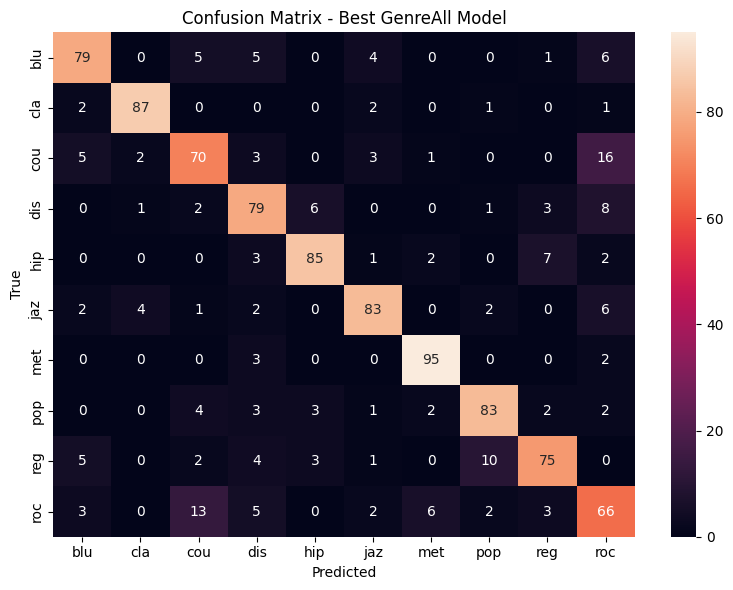

              precision    recall  f1-score   support

         blu       0.82      0.79      0.81       100
         cla       0.93      0.94      0.93        93
         cou       0.72      0.70      0.71       100
         dis       0.74      0.79      0.76       100
         hip       0.88      0.85      0.86       100
         jaz       0.86      0.83      0.84       100
         met       0.90      0.95      0.92       100
         pop       0.84      0.83      0.83       100
         reg       0.82      0.75      0.79       100
         roc       0.61      0.66      0.63       100

    accuracy                           0.81       993
   macro avg       0.81      0.81      0.81       993
weighted avg       0.81      0.81      0.81       993



In [101]:
#confusion matrix

best_model = best_rf
pred_cv = cross_val_predict(best_model, X, y, cv=cv)

labels = np.unique(y)
cm = confusion_matrix(y, pred_cv, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Best GenreAll Model")
plt.tight_layout()
plt.show()

print(classification_report(y, pred_cv))

**ALGORITHMS SUMMARY + RESOURCE ANALYSIS**

In [102]:
task1_summary = pd.DataFrame([
    {
        "dataset": "GenreAll",
        "model": "Logistic Regression",
        "accuracy_mean": res_logreg[0],
        "accuracy_std": res_logreg[1],
        "time_s": res_logreg[2],
        "peak_memory_mb": res_logreg[3],
        "emissions_kg": res_logreg[4],
    },
    {
        "dataset": "GenreAll",
        "model": "k-NN",
        "accuracy_mean": res_knn[0],
        "accuracy_std": res_knn[1],
        "time_s": res_knn[2],
        "peak_memory_mb": res_knn[3],
        "emissions_kg": res_knn[4],
    },
    {
        "dataset": "GenreAll",
        "model": "Decision Tree",
        "accuracy_mean": res_dt[0],
        "accuracy_std": res_dt[1],
        "time_s": res_dt[2],
        "peak_memory_mb": res_dt[3],
        "emissions_kg": res_dt[4],
    },
    {
        "dataset": "GenreAll",
        "model": "Random Forest",
        "accuracy_mean": res_rf[0],
        "accuracy_std": res_rf[1],
        "time_s": res_rf[2],
        "peak_memory_mb": res_rf[3],
        "emissions_kg": res_rf[4],
    },
    {
        "dataset": "GenreAll",
        "model": "MLP",
        "accuracy_mean": res_mlp[0],
        "accuracy_std": res_mlp[1],
        "time_s": res_mlp[2],
        "peak_memory_mb": res_mlp[3],
        "emissions_kg": res_mlp[4],
    },
])

task1_summary
task1_summary.to_csv("task1_results_summary.csv", index=False)

## _TASK 2_

In [103]:
df_30 = pd.read_csv("../data/features_30_sec.csv")
df_3 = pd.read_csv("../data/features_3_sec.csv")

def split_xy(df, label_col="label", drop_cols=("filename", "length")):
    X = df.drop(columns=list(drop_cols) + [label_col])
    y = df[label_col]
    return X, y

X_30, y_30 = split_xy(df_30)
X_3, y_3 = split_xy(df_3)

In [104]:
print("===== 30 sec =====")
res_30_logreg = eval_model_cv(LogisticRegression(max_iter=2000, multi_class="multinomial"), X_30, y_30, name="LogReg 30s")
res_30_knn = eval_model_cv(KNeighborsClassifier(n_neighbors=5), X_30, y_30, name="kNN 30s")
res_30_rf = eval_model_cv(RandomForestClassifier(n_estimators=200, random_state=42), X_30, y_30, name="RF 30s", use_scaler=False)

print("===== 3 sec =====")
res_3_logreg = eval_model_cv(LogisticRegression(max_iter=2000, multi_class="multinomial"), X_3, y_3, name="LogReg 3s")
res_3_knn = eval_model_cv(KNeighborsClassifier(n_neighbors=5), X_3, y_3, name="kNN 3s")
res_3_rf = eval_model_cv(RandomForestClassifier(n_estimators=200, random_state=42), X_3, y_3, name="RF 3s", use_scaler=False)

===== 30 sec =====
LogReg 30s - Accuracy CV: 0.7210 ± 0.0399
LogReg 30s - Time: 0.41 s
LogReg 30s - Peak memory: 4.17 MB
LogReg 30s - Emissions: 0.000000 kg CO2eq

kNN 30s - Accuracy CV: 0.6790 ± 0.0421
kNN 30s - Time: 0.13 s
kNN 30s - Peak memory: 1.37 MB
kNN 30s - Emissions: 0.000000 kg CO2eq

RF 30s - Accuracy CV: 0.7170 ± 0.0415
RF 30s - Time: 16.21 s
RF 30s - Peak memory: 1.12 MB
RF 30s - Emissions: 0.000009 kg CO2eq

===== 3 sec =====
LogReg 3s - Accuracy CV: 0.7240 ± 0.0175
LogReg 3s - Time: 1.94 s
LogReg 3s - Peak memory: 50.25 MB
LogReg 3s - Emissions: 0.000001 kg CO2eq

kNN 3s - Accuracy CV: 0.8932 ± 0.0084
kNN 3s - Time: 0.29 s
kNN 3s - Peak memory: 13.07 MB
kNN 3s - Emissions: 0.000000 kg CO2eq

RF 3s - Accuracy CV: 0.8824 ± 0.0075
RF 3s - Time: 93.03 s
RF 3s - Peak memory: 7.83 MB
RF 3s - Emissions: 0.000049 kg CO2eq



In [105]:
rf_30 = RandomForestClassifier(random_state=42)

param_grid_rf_30 = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_leaf": [1, 2, 4]
}

pipe_rf_30 = Pipeline([
    ("clf", rf_30)
])

grid_rf_30 = GridSearchCV(
    pipe_rf_30,
    param_grid=param_grid_rf_30,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_rf_30.fit(X_30, y_30)

print("Best RF 30s score:", grid_rf_30.best_score_)
print("Best RF 30s params:", grid_rf_30.best_params_)

Best RF 30s score: 0.719
Best RF 30s params: {'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}


In [106]:
rf_3 = RandomForestClassifier(random_state=42)

param_grid_rf_3 = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_leaf": [1, 2, 4]
}

pipe_rf_3 = Pipeline([
    ("clf", rf_3)
])

grid_rf_3 = GridSearchCV(
    pipe_rf_3,
    param_grid=param_grid_rf_3,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_rf_3.fit(X_3, y_3)

print("Best RF 3s score:", grid_rf_3.best_score_)
print("Best RF 3s params:", grid_rf_3.best_params_)

Best RF 3s score: 0.8823823823823822
Best RF 3s params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}


In [107]:
best_rf_30 = grid_rf_30.best_estimator_
pred_train_30 = best_rf_30.predict(X_30)

best_rf_3 = grid_rf_3.best_estimator_
pred_train_3 = best_rf_3.predict(X_3)

print("RF 30s Train Acc:", accuracy_score(y_30, pred_train_30))
print("RF 30s CV Acc:", grid_rf_30.best_score_)

print("RF 3s Train Acc:", accuracy_score(y_3, pred_train_3))
print("RF 3s CV Acc:", grid_rf_3.best_score_)

RF 30s Train Acc: 0.999
RF 30s CV Acc: 0.719
RF 3s Train Acc: 0.998998998998999
RF 3s CV Acc: 0.8823823823823822


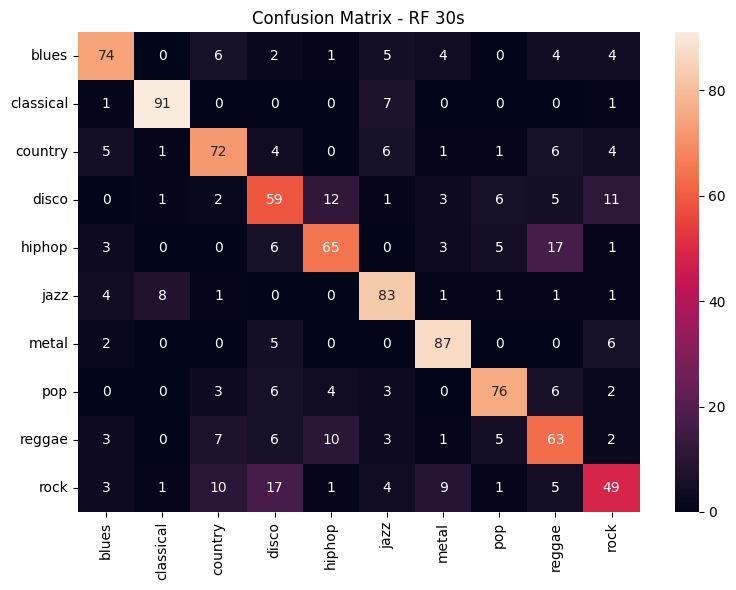

              precision    recall  f1-score   support

       blues       0.78      0.74      0.76       100
   classical       0.89      0.91      0.90       100
     country       0.71      0.72      0.72       100
       disco       0.56      0.59      0.58       100
      hiphop       0.70      0.65      0.67       100
        jazz       0.74      0.83      0.78       100
       metal       0.80      0.87      0.83       100
         pop       0.80      0.76      0.78       100
      reggae       0.59      0.63      0.61       100
        rock       0.60      0.49      0.54       100

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



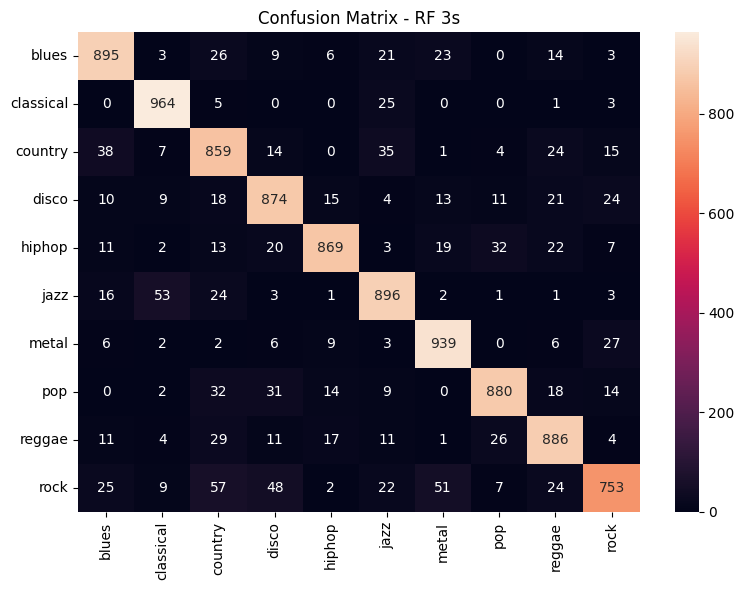

              precision    recall  f1-score   support

       blues       0.88      0.90      0.89      1000
   classical       0.91      0.97      0.94       998
     country       0.81      0.86      0.83       997
       disco       0.86      0.87      0.87       999
      hiphop       0.93      0.87      0.90       998
        jazz       0.87      0.90      0.88      1000
       metal       0.90      0.94      0.92      1000
         pop       0.92      0.88      0.90      1000
      reggae       0.87      0.89      0.88      1000
        rock       0.88      0.75      0.81       998

    accuracy                           0.88      9990
   macro avg       0.88      0.88      0.88      9990
weighted avg       0.88      0.88      0.88      9990



In [108]:
pred_cv_30 = cross_val_predict(best_rf_30, X_30, y_30, cv=cv)
labels_30 = np.unique(y_30)
cm_30 = confusion_matrix(y_30, pred_cv_30, labels=labels_30)

plt.figure(figsize=(8,6))
sns.heatmap(cm_30, annot=True, fmt="d", xticklabels=labels_30, yticklabels=labels_30)
plt.title("Confusion Matrix - RF 30s")
plt.tight_layout()
plt.show()

print(classification_report(y_30, pred_cv_30))


pred_cv_3 = cross_val_predict(best_rf_3, X_3, y_3, cv=cv)
labels_3 = np.unique(y_3)
cm_3 = confusion_matrix(y_3, pred_cv_3, labels=labels_3)

plt.figure(figsize=(8,6))
sns.heatmap(cm_3, annot=True, fmt="d", xticklabels=labels_3, yticklabels=labels_3)
plt.title("Confusion Matrix - RF 3s")
plt.tight_layout()
plt.show()

print(classification_report(y_3, pred_cv_3))

**ALGORITHMS SUMMARY + RESOURCE ANALYSIS**

In [109]:
task2_summary = pd.DataFrame([
    {
        "dataset": "features_30_sec",
        "segment_length": "30s",
        "model": "Logistic Regression",
        "accuracy_mean": res_30_logreg[0],
        "accuracy_std": res_30_logreg[1],
        "time_s": res_30_logreg[2],
        "peak_memory_mb": res_30_logreg[3],
        "emissions_kg": res_30_logreg[4],
    },
    {
        "dataset": "features_30_sec",
        "segment_length": "30s",
        "model": "k-NN",
        "accuracy_mean": res_30_knn[0],
        "accuracy_std": res_30_knn[1],
        "time_s": res_30_knn[2],
        "peak_memory_mb": res_30_knn[3],
        "emissions_kg": res_30_knn[4],
    },
    {
        "dataset": "features_30_sec",
        "segment_length": "30s",
        "model": "Random Forest",
        "accuracy_mean": res_30_rf[0],
        "accuracy_std": res_30_rf[1],
        "time_s": res_30_rf[2],
        "peak_memory_mb": res_30_rf[3],
        "emissions_kg": res_30_rf[4],
    },
    {
        "dataset": "features_3_sec",
        "segment_length": "3s",
        "model": "Logistic Regression",
        "accuracy_mean": res_3_logreg[0],
        "accuracy_std": res_3_logreg[1],
        "time_s": res_3_logreg[2],
        "peak_memory_mb": res_3_logreg[3],
        "emissions_kg": res_3_logreg[4],
    },
    {
        "dataset": "features_3_sec",
        "segment_length": "3s",
        "model": "k-NN",
        "accuracy_mean": res_3_knn[0],
        "accuracy_std": res_3_knn[1],
        "time_s": res_3_knn[2],
        "peak_memory_mb": res_3_knn[3],
        "emissions_kg": res_3_knn[4],
    },
    {
        "dataset": "features_3_sec",
        "segment_length": "3s",
        "model": "Random Forest",
        "accuracy_mean": res_3_rf[0],
        "accuracy_std": res_3_rf[1],
        "time_s": res_3_rf[2],
        "peak_memory_mb": res_3_rf[3],
        "emissions_kg": res_3_rf[4],
    },
])

task2_summary
task2_summary.to_csv("task2_results_summary.csv", index=False)